# Final project


This project is work of Ivete, Maria, Pavel, and Catherine.



# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# for downloading datasets
from google_drive_downloader import GoogleDriveDownloader as gdd

# for NNs
from keras.utils import np_utils
import keras.models as models
import keras.layers as layers
from keras import regularizers
from keras.optimizers import adam, rmsprop
import tensorflow as tf

# For CNNs
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


# Downloading datasets
This will download the data to be used in the program, from Pavel's Google Drive.
These files are downloaded: 

1.   train.npz (200 MB) - all training data (20000 samples, each 128x128 pixels), grayscale, rescaled to <0,1>
2.   train_color.npz (287 MB) - all training data, in RGB, resized to 80x80 pixels, rescaled to <0,1>
2.   labels.npz (small) - all labels for the training data (0 or 1)
3.   unknown.npz (70 MB) - 7000 unclassified samples, to be classified by our great model, rescaled to <0,1>, grayscale
4.   unknown_color.npz (99 MB) - same as above, but in color and resized to 80x80

These files are then converted into numpy arrays.

In [ ]:
# downloading files
gdd.download_file_from_google_drive(file_id='1puyJUxClNa6uKdQLGDtk2vYAt1_PikA8',dest_path='./data/train.npz')
# RGB version, but resized to 80x80
gdd.download_file_from_google_drive(file_id='1iIpQYSyr5NKsfAnlblTmPr9B_3kqaNQi',dest_path='./data/train_color.npz')
gdd.download_file_from_google_drive(file_id='1MEIQC73aCgcVyFir7KaPIKC1I0XAcYmX',dest_path='./data/labels.npz')
gdd.download_file_from_google_drive(file_id='10LMA8mgKrJDEreAQrgTT32nrLS39RJtn',dest_path='./data/unknown.npz')
gdd.download_file_from_google_drive(file_id='11C7ZupV23XKXb_fL-QVa7ba3FO3U3kFb',dest_path='./data/unknown_color.npz')

# converting them into 3 numpy arrays (train, labels, unknown)
train_loaded = np.load('./data/train.npz')
train_color_loaded = np.load('./data/train_color.npz')
labels_loaded = np.load('./data/labels.npz')
unknown_loaded = np.load('./data/unknown.npz')
unknown_color_loaded = np.load('./data/unknown_color.npz')

# from now on, these are numpy arrays
train = train_loaded['arr_0']
train_color = train_color_loaded['arr_0']
labels = labels_loaded['arr_0']
unknown = unknown_loaded['arr_0']
unknown_color = unknown_color_loaded['arr_0']

In [ ]:
# checking that we have the dimensions right
print("------  shapes -------------------")
print("Train dataset:", train.shape)
print("Train color dataset:", train_color.shape)
print("Labels dataset:", labels.shape)
print("Unknown dataset:", unknown.shape)
print("Unknown color dataset:", unknown_color.shape)


------  shapes -------------------
Train dataset: (20000, 128, 128)
Train color dataset: (20000, 80, 80, 3)
Labels dataset: (20000,)
Unknown dataset: (7000, 128, 128)
Unknown color dataset: (7000, 80, 80, 3)


Show a few pictures with correct labels

0 = not infected
1 = infected

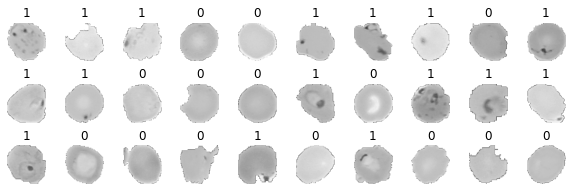

In [ ]:
random_pictures = np.random.randint(0, train.shape[0], 30)
plt.figure(figsize=(10,3))
for i, n in enumerate(random_pictures):
    ax = plt.subplot(3,10,i+1)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train[n], cmap="gray")
    plt.title(str(labels[n]))
    plt.axis("off")
plt.show()

Again, some pictures, but in RGB

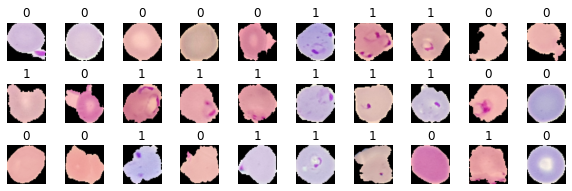

In [ ]:
random_pictures = np.random.randint(0, train_color.shape[0], 30)
plt.figure(figsize=(10,3))
for i, n in enumerate(random_pictures):
    ax = plt.subplot(3,10,i+1)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_color[n])
    plt.title(str(labels[n]))
    plt.axis("off")
plt.show()

For machine learning methods and plain neural networks, we need to flatten the image to a vector.

In [ ]:
# the neural networks expect a 1D column of values as input
# now is the time to flatten the 28*28 arrays to 1d vectors, so 128x128 = 16384 
length = train.shape[0]
train_flattened = train.reshape((length, 128*128))
print("New shape of the flattened dataset", train_flattened.shape)

New shape of the flattened dataset (20000, 16384)


# Split data into training and validation sets
Of the 20k samples, we use 20% as validation split

In [ ]:
# split into training and testing sets
# shuffle is True by default, but it is better to make it explicit. Shuffling is important!
X_train, X_test, y_train, y_test = train_test_split(train_flattened, labels, test_size=0.20, shuffle=True)
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

print("Shape X_train", X_train.shape)
print("Shape X_test", X_test.shape)
print("Shape y_train", y_train.shape)
print("Shape y_test", y_test.shape)
print("------------------------------------")
print("Type X_train", X_train.dtype)
print("Type X_test", X_test.dtype)
print("Type y_train", y_train.dtype)
print("Type y_test", y_test.dtype)

# how balanced are the labels in the training dataset? 
print("Percentage of infected (should be close to 0.5):", np.sum(labels) / labels.size)

Shape X_train (16000, 16384)
Shape X_test (4000, 16384)
Shape y_train (16000, 2)
Shape y_test (4000, 2)
------------------------------------
Type X_train float64
Type X_test float64
Type y_train float32
Type y_test float32
Percentage of infected (should be close to 0.5): 0.4952


# Plain neural networks


## Specifying the NN model
First try: 

*   Sequential model
*   Hidden layer with Re-lu activation, 1024 neurons
*   Hidden layer with Re-lu activation, 1024 neurons
*   Output layer, 1 neuron (0 or 1), 

**Note the very high number of parameters!**
Dataset used: grayscale, full resolution (128x128)




In [ ]:
nn = models.Sequential()
nn.add(layers.Dense(1024, activation = 'relu', input_shape = (128*128, )))
nn.add(layers.Dense(1024, activation = 'relu'))
nn.add(layers.Dense(2, activation = 'sigmoid'))

# alternative for optimiser : rmsprop
nn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              16778240  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 17,829,890
Trainable params: 17,829,890
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [ ]:
np.random.seed(9898)
tf.random.set_seed(9777)
num_epochs = 10

# we include the validation data in the model
r = nn.fit(X_train, y_train, 
           epochs = num_epochs, 
           batch_size = 64, 
           validation_data = (X_test, y_test))

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
 7936/16000 [=============>................] - ETA: 32s - loss: 0.7456 - accuracy: 0.5025

KeyboardInterrupt: ignored

Plot the training and validation accuracy

In [ ]:
def plot_accuracy(r):
    train_acc = r.history['accuracy']
    test_acc = r.history['val_accuracy']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'test accuracy')
    plt.plot(x, train_acc, label = 'training accuracy')  
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')  
    plt.legend(loc='right')
    plt.show()
    
plot_accuracy(r)

NameError: ignored

Very dissappointing results! Even worse than random guessing 😄😄 

# Convolutional neural networks (CNNs)

When you look at the pictures, the key features of the infected cells are the grey, darker spots, which are not present in the clean cells. 

It would perhaps make sense to run a convolutional filter over the images, to be able to pinpoint the darker spots in the pictures. The CNNs should be able to capture this.

For CNNs, we first used the grayscale version, but the results were not great. We will try to use RGB version, but resized to 80x80.

Unlike in the plain NNs, we dont need to flatten the image before use.

In [ ]:
# prepare the data correctly for the CNNs
# no flattening at first (flattening is done later in the CNN model)
# however, even if we have grayscale images, the CNN expects a 3D array
# train_cnn = train.reshape((train.shape[0], 128, 128, 1))
print("train_color shape is", train_color.shape)

X_train, X_test, y_train, y_test = train_test_split(train_color, labels, test_size=0.20, shuffle=True)
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

print("Shape X_train", X_train.shape)
print("Shape X_test", X_test.shape)
print("Shape y_train", y_train.shape)
print("Shape y_test", y_test.shape)
print("------------------------------------")
print("Type X_train", X_train.dtype)
print("Type X_test", X_test.dtype)
print("Type y_train", y_train.dtype)
print("Type y_test", y_test.dtype)

train_color shape is (20000, 80, 80, 3)
Shape X_train (16000, 80, 80, 3)
Shape X_test (4000, 80, 80, 3)
Shape y_train (16000, 2)
Shape y_test (4000, 2)
------------------------------------
Type X_train float64
Type X_test float64
Type y_train float32
Type y_test float32


## Defining the CNN model - first test

In [ ]:
cnn = Sequential()

# even if we use only 1 channel, we still need to supply a 3D array, 
# hence 1 in the input shape (would use 3 if RGB)
# cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', input_shape = (128, 128, 1)))

# conv2d layer (https://keras.io/api/layers/convolution_layers/convolution2d/)
# kernel_size 3x3 = a square 3 pixels times 3 pixels
# filters = number of output filters (affects the number of dimensions in the output, 
# see the model summary, column "Output shape")
# stride is untouched, so kept at 1,1 (one step right or down)

# max pooling - simply creates a reduced output where we run a grid of 
# 2x2 pixels and output the max value from this grid, this reduces the size of 
# the output dataset

# Batch normalisation
# training = True
# https://keras.io/api/layers/normalization_layers/batch_normalization/

# prent overfitting: dropout .2 means there is 20% chance that a given 
# neuron/connection will be reset 
# https://keras.io/api/layers/regularization_layers/dropout/

# since we have three rounds of the conv2d and pooling layers, the 
# final layer is very tiny, only 8x8 pixels (though 32 layers deep)

# ROUND 1
cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', input_shape = (80, 80, 3)))
cnn.add(MaxPooling2D(2,2))
cnn.add(BatchNormalization(axis = -1))
cnn.add(Dropout(0.2))

# ROUND 2
cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu'))
cnn.add(MaxPooling2D(2,2))
cnn.add(BatchNormalization(axis = -1))
cnn.add(Dropout(0.2))

# ROUND 3
cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu'))
cnn.add(MaxPooling2D(2,2))
cnn.add(BatchNormalization(axis = -1))
cnn.add(Dropout(0.2))

# last layer is a regular dense hidden layer, as in a normal neural network
# so we need to flatten
cnn.add(Flatten())

# note the fairly high dropout as compared to conv layers
cnn.add(Dense(512, activation = 'relu'))
cnn.add(BatchNormalization(axis = -1))
cnn.add(Dropout(0.5))
# last, output layer, two neurons
cnn.add(Dense(2, activation = 'sigmoid'))

# compile
# we have separated the two output values, hence we use categorical_crossentropy
# but i guess we can as well use binary_crossentropy? or do we need only one neuron 
# in the output layer?
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 39, 39, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 18, 32)       

## Training the CNN model
Time needed: 2.5 min per epoch for 80x80 RGB, 12 min for grayscale 128x128

In [ ]:
r = cnn.fit(X_train, y_train, 
            epochs = 5, 
            batch_size = 32 , 
            validation_data=(X_test, y_test))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 148s 9ms/step - loss: 0.5520 - accuracy: 0.7346 - val_loss: 2.3637 - val_accuracy: 0.5138
Epoch 2/5
16000/16000 [==============================] - 146s 9ms/step - loss: 0.2164 - accuracy: 0.9209 - val_loss: 0.3336 - val_accuracy: 0.9005
Epoch 3/5
16000/16000 [==============================] - 149s 9ms/step - loss: 0.1763 - accuracy: 0.9391 - val_loss: 0.2313 - val_accuracy: 0.9265
Epoch 4/5
16000/16000 [==============================] - 152s 10ms/step - loss: 0.1586 - accuracy: 0.9454 - val_loss: 0.3272 - val_accuracy: 0.9110
Epoch 5/5
16000/16000 [==============================] - 151s 9ms/step - loss: 0.1521 - accuracy: 0.9474 - val_loss: 0.1645 - val_accuracy: 0.9430


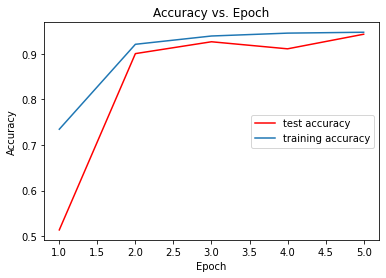

In [ ]:
plot_accuracy(r)

## Results - 94% validation accuracy

Validation accuracy: 94%. Good enough for us 🙂 maybe more epochs would still improve the val accuracy?

 let's try to predict the labels for the 7000 unknown samples. Dont forget to download the CSV file! Alternative: share the whole notebook with Kevin.

In [ ]:
predictions = cnn.predict_classes(unknown_color)
print("Shape of the predictions:", predictions.shape)
print(predictions)

# export results to CSV (170 KB)
np.savetxt("result_classifications.csv", predictions, delimiter=",")

Shape of the predictions: (7000,)
[1 1 1 ... 0 1 1]


## Defining the final CNN model

In [ ]:
# I changed the input_shape (using RGB resized pictures, changed the name of the model, otherwise untouched)
cnn_final = Sequential()

# we have 3 layers of convolutional+pooling layers
# the model works better with the RGB version
# resizing to 80x80 pixels didnt seem to harm the performance

# conv2d layer (https://keras.io/api/layers/convolution_layers/convolution2d/)
# kernel_size 3x3 = a square 3 pixels times 3 pixels
# filters = number of output filters (affects the number of dimensions in the output, 
# see the model summary, column "Output shape")
# stride is untouched, so kept at 1,1 (one step right or down)

# max pooling - simply creates a reduced output where we run a grid of 
# 2x2 pixels and output the max value from this grid, this reduces the size of 
# the output dataset

# prent overfitting: dropout .3 means there is 30% chance that a given 
# neuron/connection will be reset 
# https://keras.io/api/layers/regularization_layers/dropout/


# convolutional layer #1
cnn_final.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', input_shape = (80, 80, 3)))
cnn_final.add(MaxPooling2D(2,2))

# convolutional layer #2
cnn_final.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu'))
cnn_final.add(MaxPooling2D(2,2))

# convolutional layer #3
cnn_final.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu'))
cnn_final.add(MaxPooling2D(2,2))

# now we switch to two regular dense layers (each 512 neurons), 
# so first we need to flatten
cnn_final.add(Flatten())
cnn_final.add(Dense(512, activation = 'relu'))
cnn_final.add(Dropout(0.3))
cnn_final.add(Dense(512, activation = 'relu'))
cnn_final.add(Dropout(0.3))
cnn_final.add(Dense(2, activation = 'sigmoid'))

# compile and print summary of the model
# note how the output shape decreases down to 8x8 pixels in the 3rd round
cnn_final.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
cnn_final.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)             

## Training the final CNN model

In [ ]:
# training the model, the validation dataset is included already in the model
r = cnn_final.fit(X_train, y_train, 
            epochs = 5, 
            batch_size = 32 , 
            validation_data=(X_test, y_test))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 129s 8ms/step - loss: 0.3301 - accuracy: 0.8402 - val_loss: 0.1489 - val_accuracy: 0.9542
Epoch 2/5
16000/16000 [==============================] - 127s 8ms/step - loss: 0.1436 - accuracy: 0.9544 - val_loss: 0.1362 - val_accuracy: 0.9594
Epoch 3/5
16000/16000 [==============================] - 126s 8ms/step - loss: 0.1326 - accuracy: 0.9562 - val_loss: 0.1397 - val_accuracy: 0.9566
Epoch 4/5
16000/16000 [==============================] - 125s 8ms/step - loss: 0.1246 - accuracy: 0.9580 - val_loss: 0.1396 - val_accuracy: 0.9554
Epoch 5/5
16000/16000 [==============================] - 124s 8ms/step - loss: 0.1108 - accuracy: 0.9638 - val_loss: 0.1293 - val_accuracy: 0.9579


## Final model results: 95.8% validation accuracy after only 5 epochs!
In fact, we would get even better results if we stopped after the 2nd epoch

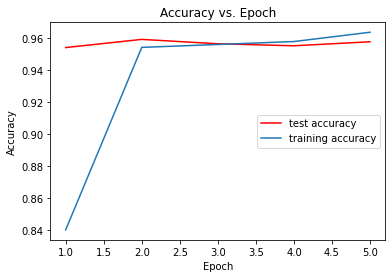

In [ ]:
# plot accuracy from final model
plot_accuracy(r)


In [ ]:
# create predictions and export to CSV
predictions = cnn_final.predict_classes(unknown_color)
print("Shape of the predictions:", predictions.shape)
print(predictions)

# export results to CSV (170 KB)
# the labels correspond to the images, sorted alphabetically, ie 20000.jpg, 20001.jpg, ..., 26999.jpg
np.savetxt("result_classifications.csv", predictions, delimiter=",")